In [525]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json
import os

In [528]:
BASE = os.path.dirname(os.getcwd())
EVAL_BASE_DIRECTORY = f"{BASE}/data/wildbench_hard/results"
REPORT_FILENAME = "report_evaluations_evaluations.json"
RUBRICATORS = ["o3-2025-04-16_as_rubricator", "gpt-4.1-2025-04-14_as_rubricator", "gpt-4.1-nano-2025-04-14_as_rubricator", "wildbench", "baseline"]
EVALUATORS = ["gpt-4.1-2025-04-14_as_evaluator", "gpt-4.1-mini-2025-04-14_as_evaluator", "gpt-4.1-nano-2025-04-14_as_evaluator"]

In [653]:
plt.rc("font", family = "avenir")

In [523]:
def get_eval_results(rubricator, evaluator, print_stats = False):
    eval_directory = f"{EVAL_BASE_DIRECTORY}/{rubricator}/{evaluator}"
    
    model_list = []
    score_list = []
    error_list = []
    
    for dir in os.listdir(eval_directory):
        filename = f"{eval_directory}/{dir}/{REPORT_FILENAME}"
        if os.path.exists(filename):
            with open(filename) as f:
                report = json.load(f)
                model_list.append(report["model"])
                score_list.append(round(float(report["weighted_score_mean"]), 2))
                error_list.append(round(float(report["weighted_score_sem"]), 2))
        else:
            print(f"ERROR: file {filename} does not exist")

    if print_stats:
        print(f"Rubricator: {rubricator}")
        print(f"Evaluator: {evaluator}")
        print(f"# of models: {len(model_list)}\n")
    
    df = pd.DataFrame()
    df["model"] = model_list
    df["score"] = score_list
    df["error"] = error_list
    df = df.sort_values(by = ["score"], ascending = False).reset_index(drop = True)

    return df

In [291]:
def plot_scores(df):
    plt.figure(figsize = (18, 10))
    plt.scatter(x = df["model"], y = df["score"], color = "black")
    plt.errorbar(x = df["model"], y = df["score"], yerr = df["error"], fmt = "none", ecolor = "black", capsize = 5)
    plt.xticks(rotation = 90)
    plt.tight_layout()
    plt.show()

In [383]:
def rename_models(model_scores):
    # Rename some models to match LMArena
    model_scores["deepseek-v3-0324"] = model_scores.pop("deepseek-v3")
    model_scores["o3-mini"] = model_scores.pop("o3-mini-2025-01-31")
    model_scores["o1-mini"] = model_scores.pop("o1-mini-2024-09-12")
    model_scores["llama-4-maverick-17b-128e-instruct"] = model_scores.pop("llama-4-maverick-17b-128e-instruct-fp8")
    model_scores["llama-3.3-70b-instruct"] = model_scores.pop("llama-3.3-70b-instruct-turbo")
    model_scores["llama-3.1-70b-instruct"] = model_scores.pop("meta-llama-3.1-70b-instruct-turbo")
    model_scores["llama-3.1-405b-instruct-bf16"] = model_scores.pop("meta-llama-3.1-405b-instruct-turbo")
    model_scores["llama-3.1-8b-instruct"] = model_scores.pop("meta-llama-3.1-8b-instruct-turbo")
    model_scores["qwen2.5-72b-instruct"] = model_scores.pop("qwen2.5-72b-instruct-turbo")
    model_scores["qwen2.5-7b-instruct"] = model_scores.pop("qwen2.5-7b-instruct-turbo")
    model_scores["gemini-2.0-flash-001"] = model_scores.pop("gemini-2.0-flash")
    model_scores["gemini-2.0-flash-lite-preview-02-05"] = model_scores.pop("gemini-2.0-flash-lite")
    model_scores["gemini-1.5-pro-002"] = model_scores.pop("gemini-1.5-pro")
    model_scores["gemini-1.5-flash-002"] = model_scores.pop("gemini-1.5-flash")
    model_scores["gemini-2.5-pro-exp-03-25"] = model_scores.pop("gemini-2.5-pro-preview-03-25")

In [530]:
'''
Arena categories:
['french', 'full_style_control', 'full', 'creative_writing',
'creative_writing_style_control', 'coding', 'coding_style_control',
'if', 'if_style_control', 'math', 'math_style_control',
'hard_6_style_control', 'hard_6', 'hard_english_6', 'english',
'chinese', 'multiturn', 'multiturn_style_control',
'long_user', 'long_user_style_control', 'german', 'spanish',
'russian', 'japanese', 'korean', 'no_tie', 'no_short', 'no_refusal']
'''

# Pull data from 04/23/25 LMArena update
lmaElos = {}
with open(f"{BASE}/data/lmarena/elo_results_20250423.pkl", "rb") as f:
    lmaData = pickle.load(f)["text"]
    for arena in lmaData.keys():
        lmaDf = lmaData[arena]["elo_rating_final"].reset_index()
        lmaDf.columns = ["model", "elo"]
        lmaElos[arena] = {model.lower(): elo for model, elo in zip(list(lmaDf["model"]), list(lmaDf["elo"]))}

In [458]:
def calc_correlations(model_scores, arena, print_stats = False, plot = False, top_n = None):
    modelElos = lmaElos[arena]
    models = [model for model in model_scores if model in modelElos]
    scores, elos = [model_scores[model] for model in models], [modelElos[model] for model in models]

    if top_n:
        combined = list(zip(elos, scores, models))
        combined.sort(reverse = True)
        combined = combined[:top_n]
        elos, scores, models = zip(*combined)
        elos, scores, models = list(elos), list(scores), list(models)
    
    spearman_corr, spearman_pval = spearmanr(scores, elos)
    pearson_corr, pearson_pval = pearsonr(scores, elos)

    if print_stats:
        print(f"Arena: {arena} ({len(models)} models)")
        print(f"Spearman: correlation = {spearman_corr:.3f}, p-value = {spearman_pval:.3e}")
        print(f"Pearson: correlation = {pearson_corr:.3f}, p-value = {pearson_pval:.3e}\n")
    
    if plot:
        plt.figure(figsize = (18, 8))
        plt.scatter(scores, elos)
        plt.xlabel("RubricEval Score")
        plt.ylabel("LMArena ELO")
        for i, model in enumerate(models):
            plt.text(scores[i] + 0.015, elos[i] + 2.5, model, fontsize = 8, rotation = 5)
        plt.show()

    return spearman_corr, pearson_corr, len(scores)

In [684]:
def create_correlation_table(correlations):
    df = pd.DataFrame(correlations, columns = ["evaluator", "rubricator", "correlation"])
    table = df.pivot(index = "evaluator", columns = "rubricator", values = "correlation")
    table = table[["o3-2025-04-16_as_rubricator", "gpt-4.1-2025-04-14_as_rubricator", "gpt-4.1-nano-2025-04-14_as_rubricator", "wildbench", "baseline"]]
    table.columns = ["o3-2025-04-16_as_rubricator", "gpt-4.1-2025-04-14_as_rubricator", "gpt-4.1-nano-2025-04-14_as_rubricator", "wildbench_baseline", "naive_baseline"]
    return table

In [693]:
def get_correlation_tables(arenas, metric, top_n = None, print_stats = False):
    tables = []
    
    for arena in arenas:
        correlations = []
        
        for rubricator in RUBRICATORS:
            for evaluator in EVALUATORS:
                df = get_eval_results(rubricator, evaluator)
                model_scores = {model.lower(): score for model, score in zip(list(df["model"]), list(df["score"]))}
                rename_models(model_scores)
                spearman_corr, pearson_corr, n_models = calc_correlations(model_scores, arena, top_n = top_n, plot = False)
                if metric == "pearson":
                    correlations.append((evaluator, rubricator, round(pearson_corr, 3)))
                else:
                    correlations.append((evaluator, rubricator, round(spearman_corr, 3)))
        
        table = create_correlation_table(correlations)

        if print_stats:
            print(f"Arena: {arena}, Metric: {metric}, N models: {n_models}")
            display(table)
            print("\n\n")

        tables.append(table)

    return tables

In [686]:
arenas = ["full", "full_style_control", "hard_6", "hard_english_6"]
tables = get_correlation_tables(arenas, "pearson", print_stats = True)

Arena: full, Metric: pearson, N models: 31


,o3-2025-04-16_as_rubricator,gpt-4.1-2025-04-14_as_rubricator,gpt-4.1-nano-2025-04-14_as_rubricator,wildbench_baseline,naive_baseline
evaluator,,,,,
gpt-4.1-2025-04-14_as_evaluator,0.935,0.940,0.927,0.924,0.910
gpt-4.1-mini-2025-04-14_as_evaluator,0.936,0.928,0.908,0.892,0.867
gpt-4.1-nano-2025-04-14_as_evaluator,0.930,0.902,0.883,0.858,0.844





Arena: full_style_control, Metric: pearson, N models: 31


,o3-2025-04-16_as_rubricator,gpt-4.1-2025-04-14_as_rubricator,gpt-4.1-nano-2025-04-14_as_rubricator,wildbench_baseline,naive_baseline
evaluator,,,,,
gpt-4.1-2025-04-14_as_evaluator,0.934,0.927,0.908,0.912,0.898
gpt-4.1-mini-2025-04-14_as_evaluator,0.927,0.908,0.883,0.872,0.843
gpt-4.1-nano-2025-04-14_as_evaluator,0.888,0.867,0.849,0.849,0.810





Arena: hard_6, Metric: pearson, N models: 31


,o3-2025-04-16_as_rubricator,gpt-4.1-2025-04-14_as_rubricator,gpt-4.1-nano-2025-04-14_as_rubricator,wildbench_baseline,naive_baseline
evaluator,,,,,
gpt-4.1-2025-04-14_as_evaluator,0.954,0.963,0.952,0.951,0.934
gpt-4.1-mini-2025-04-14_as_evaluator,0.959,0.955,0.934,0.922,0.901
gpt-4.1-nano-2025-04-14_as_evaluator,0.952,0.921,0.908,0.886,0.886





Arena: hard_english_6, Metric: pearson, N models: 31


,o3-2025-04-16_as_rubricator,gpt-4.1-2025-04-14_as_rubricator,gpt-4.1-nano-2025-04-14_as_rubricator,wildbench_baseline,naive_baseline
evaluator,,,,,
gpt-4.1-2025-04-14_as_evaluator,0.948,0.956,0.946,0.943,0.930
gpt-4.1-mini-2025-04-14_as_evaluator,0.954,0.951,0.932,0.919,0.902
gpt-4.1-nano-2025-04-14_as_evaluator,0.947,0.915,0.908,0.881,0.884


In [687]:
arenas = ["full", "full_style_control", "hard_6", "hard_english_6"]
tables = get_correlation_tables(arenas, "spearman", print_stats = True)

Arena: full, Metric: spearman, N models: 31


,o3-2025-04-16_as_rubricator,gpt-4.1-2025-04-14_as_rubricator,gpt-4.1-nano-2025-04-14_as_rubricator,wildbench_baseline,naive_baseline
evaluator,,,,,
gpt-4.1-2025-04-14_as_evaluator,0.943,0.954,0.945,0.946,0.953
gpt-4.1-mini-2025-04-14_as_evaluator,0.934,0.944,0.938,0.940,0.929
gpt-4.1-nano-2025-04-14_as_evaluator,0.927,0.926,0.916,0.933,0.892





Arena: full_style_control, Metric: spearman, N models: 31


,o3-2025-04-16_as_rubricator,gpt-4.1-2025-04-14_as_rubricator,gpt-4.1-nano-2025-04-14_as_rubricator,wildbench_baseline,naive_baseline
evaluator,,,,,
gpt-4.1-2025-04-14_as_evaluator,0.948,0.957,0.944,0.952,0.955
gpt-4.1-mini-2025-04-14_as_evaluator,0.936,0.942,0.933,0.945,0.925
gpt-4.1-nano-2025-04-14_as_evaluator,0.898,0.915,0.909,0.923,0.889





Arena: hard_6, Metric: spearman, N models: 31


,o3-2025-04-16_as_rubricator,gpt-4.1-2025-04-14_as_rubricator,gpt-4.1-nano-2025-04-14_as_rubricator,wildbench_baseline,naive_baseline
evaluator,,,,,
gpt-4.1-2025-04-14_as_evaluator,0.957,0.967,0.956,0.961,0.957
gpt-4.1-mini-2025-04-14_as_evaluator,0.955,0.960,0.960,0.957,0.947
gpt-4.1-nano-2025-04-14_as_evaluator,0.937,0.944,0.942,0.942,0.921





Arena: hard_english_6, Metric: spearman, N models: 31


,o3-2025-04-16_as_rubricator,gpt-4.1-2025-04-14_as_rubricator,gpt-4.1-nano-2025-04-14_as_rubricator,wildbench_baseline,naive_baseline
evaluator,,,,,
gpt-4.1-2025-04-14_as_evaluator,0.954,0.959,0.947,0.950,0.948
gpt-4.1-mini-2025-04-14_as_evaluator,0.951,0.951,0.952,0.949,0.939
gpt-4.1-nano-2025-04-14_as_evaluator,0.928,0.938,0.930,0.931,0.912


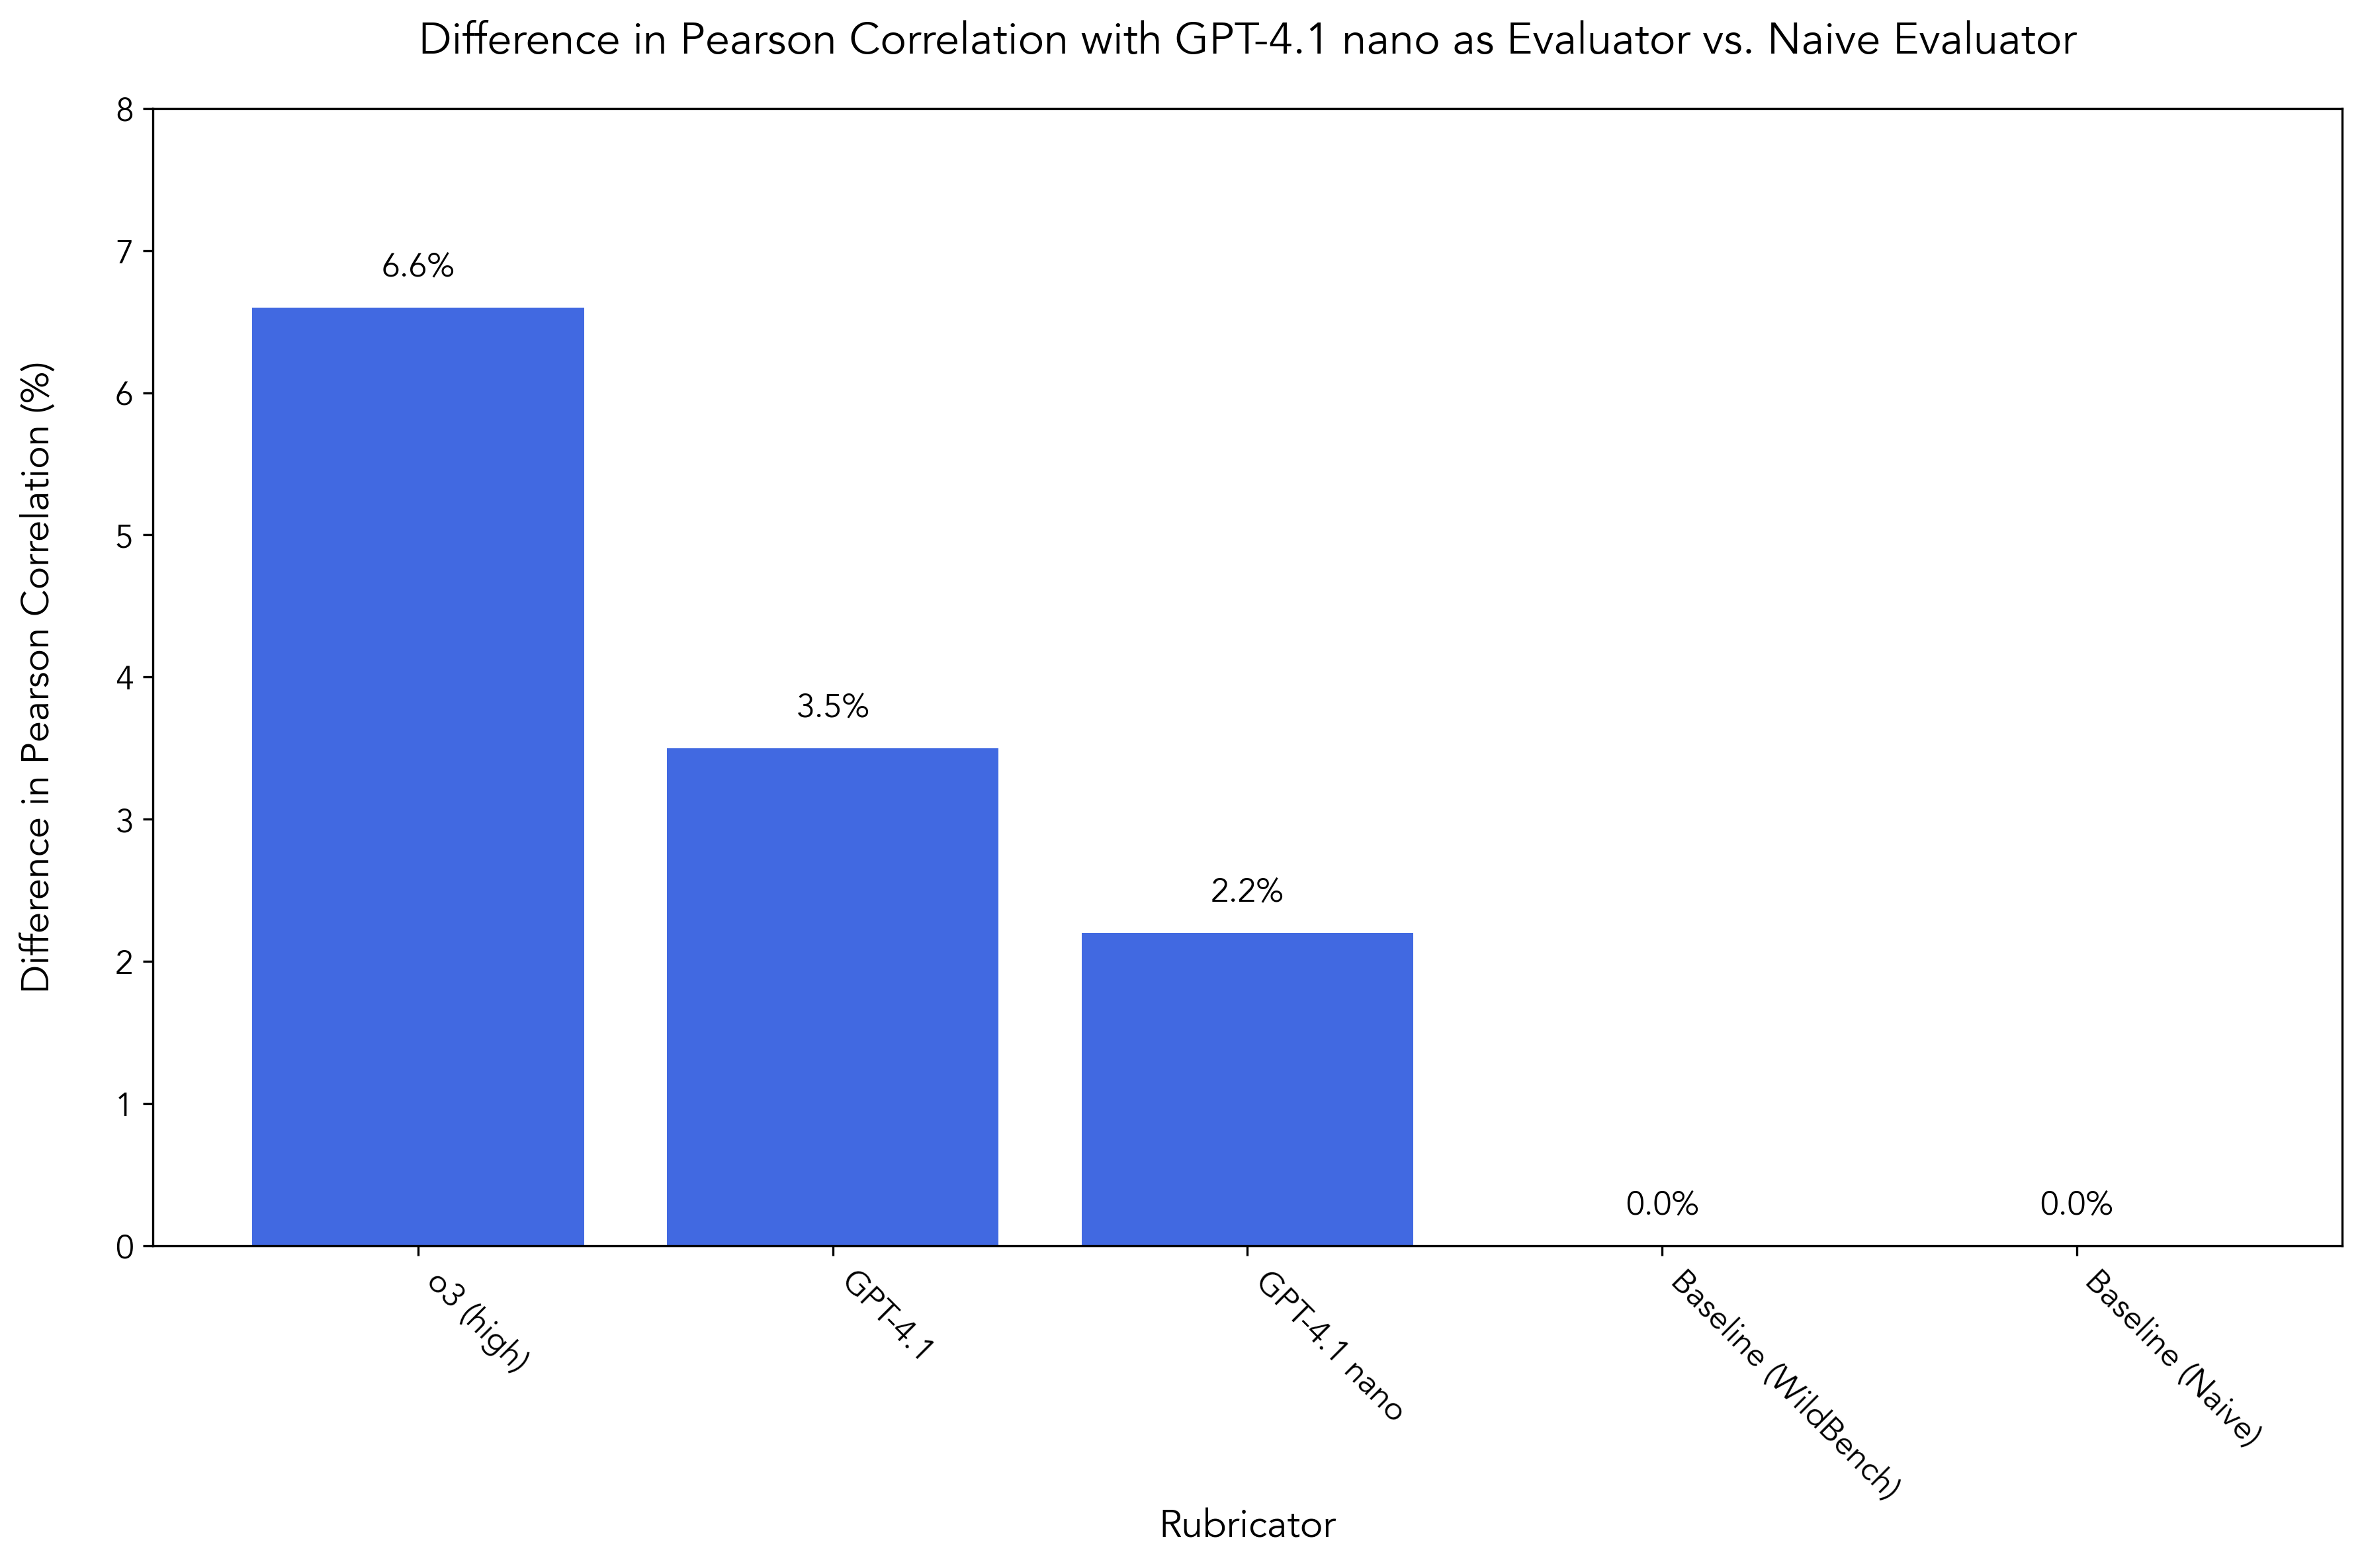

In [668]:
table = get_correlation_tables(["hard_6"], "pearson")[0]
nano_correlations = table.loc["gpt-4.1-nano-2025-04-14_as_evaluator"]
nano_baseline = nano_correlations.loc["naive_baseline"]
rubricator_pretty_names = ["o3 (high)", "GPT-4.1", "GPT-4.1 nano", "Baseline (WildBench)", "Baseline (Naive)"]
baseline_diffs = [(correlation - nano_baseline) * 100 for correlation in nano_correlations]

fig = plt.figure(figsize = (12, 8), dpi = 300)
plt.bar(rubricator_pretty_names, baseline_diffs, color = "royalblue")
for i, height in enumerate(baseline_diffs):
    label_text = format(height, ".1f") + "%"
    plt.annotate(label_text, (i, height), ha = "center", va = "center", xytext = (0, 14), textcoords = "offset points", fontsize = 12)
plt.xticks(rotation = 315, ha = "left")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0, 8)
plt.xlabel("Rubricator", fontsize = 14, labelpad = 0)
plt.ylabel("Difference in Pearson Correlation (%)", fontsize = 14, labelpad = 20)
plt.title("Difference in Pearson Correlation with GPT-4.1 nano as Evaluator vs. Naive Evaluator", fontsize = 16, fontweight = "bold", pad = 20)
plt.tight_layout()
plt.show()

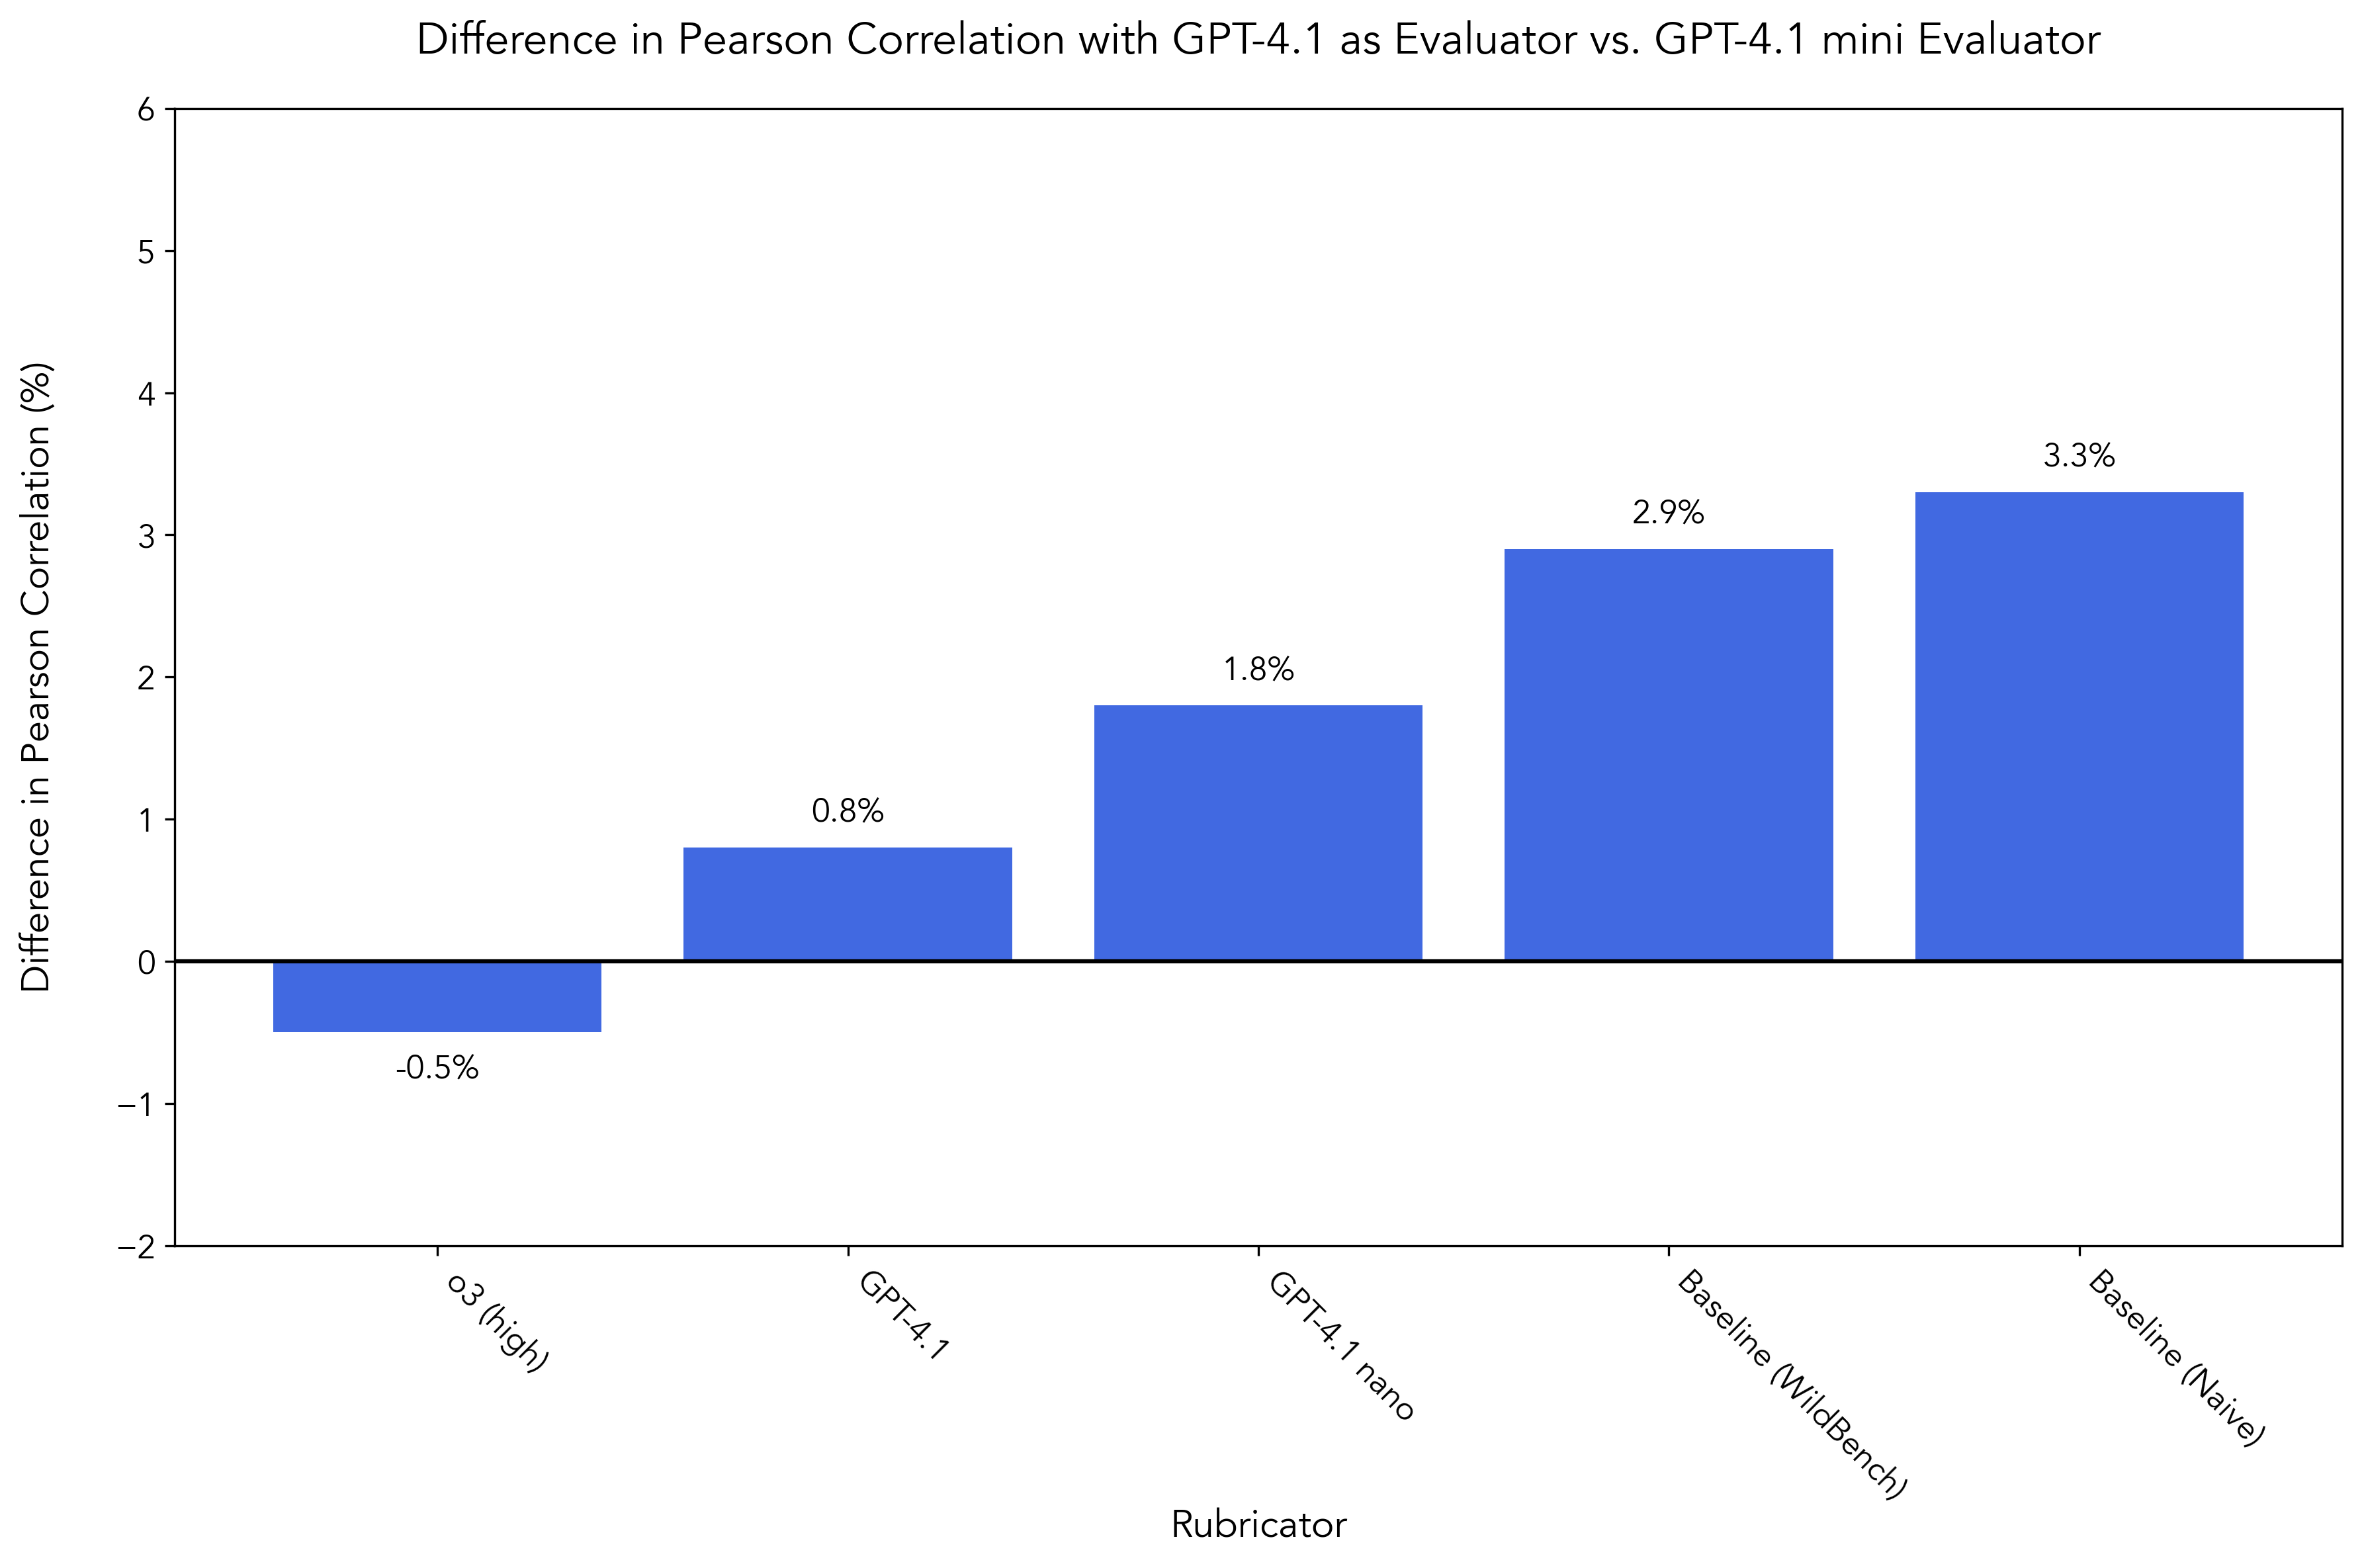

In [672]:
table = get_correlation_tables(["hard_6"], "pearson")[0]
reg_correlations = table.loc["gpt-4.1-2025-04-14_as_evaluator"]
mini_correlations = table.loc["gpt-4.1-mini-2025-04-14_as_evaluator"]
rubricator_pretty_names = ["o3 (high)", "GPT-4.1", "GPT-4.1 nano", "Baseline (WildBench)", "Baseline (Naive)"]
diffs = [(reg_corr - mini_corr) * 100 for reg_corr, mini_corr in zip(reg_correlations, mini_correlations)]

fig = plt.figure(figsize = (12, 8), dpi = 300)
plt.bar(rubricator_pretty_names, diffs, color = "royalblue")
for i, height in enumerate(diffs):
    label_text = format(height, ".1f") + "%"
    if height > 0:
        plt.annotate(label_text, (i, height), ha = "center", va = "center", xytext = (0, 12), textcoords = "offset points", fontsize = 12)
    else:
        plt.annotate(label_text, (i, height), ha = "center", va = "center", xytext = (0, -14), textcoords = "offset points", fontsize = 12)
plt.xticks(rotation = 315, ha = "left")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(-2, 6)
plt.axhline(y = 0, color = "black")
plt.xlabel("Rubricator", fontsize = 14, labelpad = 0)
plt.ylabel("Difference in Pearson Correlation (%)", fontsize = 14, labelpad = 20)
plt.title("Difference in Pearson Correlation with GPT-4.1 as Evaluator vs. GPT-4.1 mini Evaluator", fontsize = 16, pad = 20)
plt.tight_layout()
plt.show()

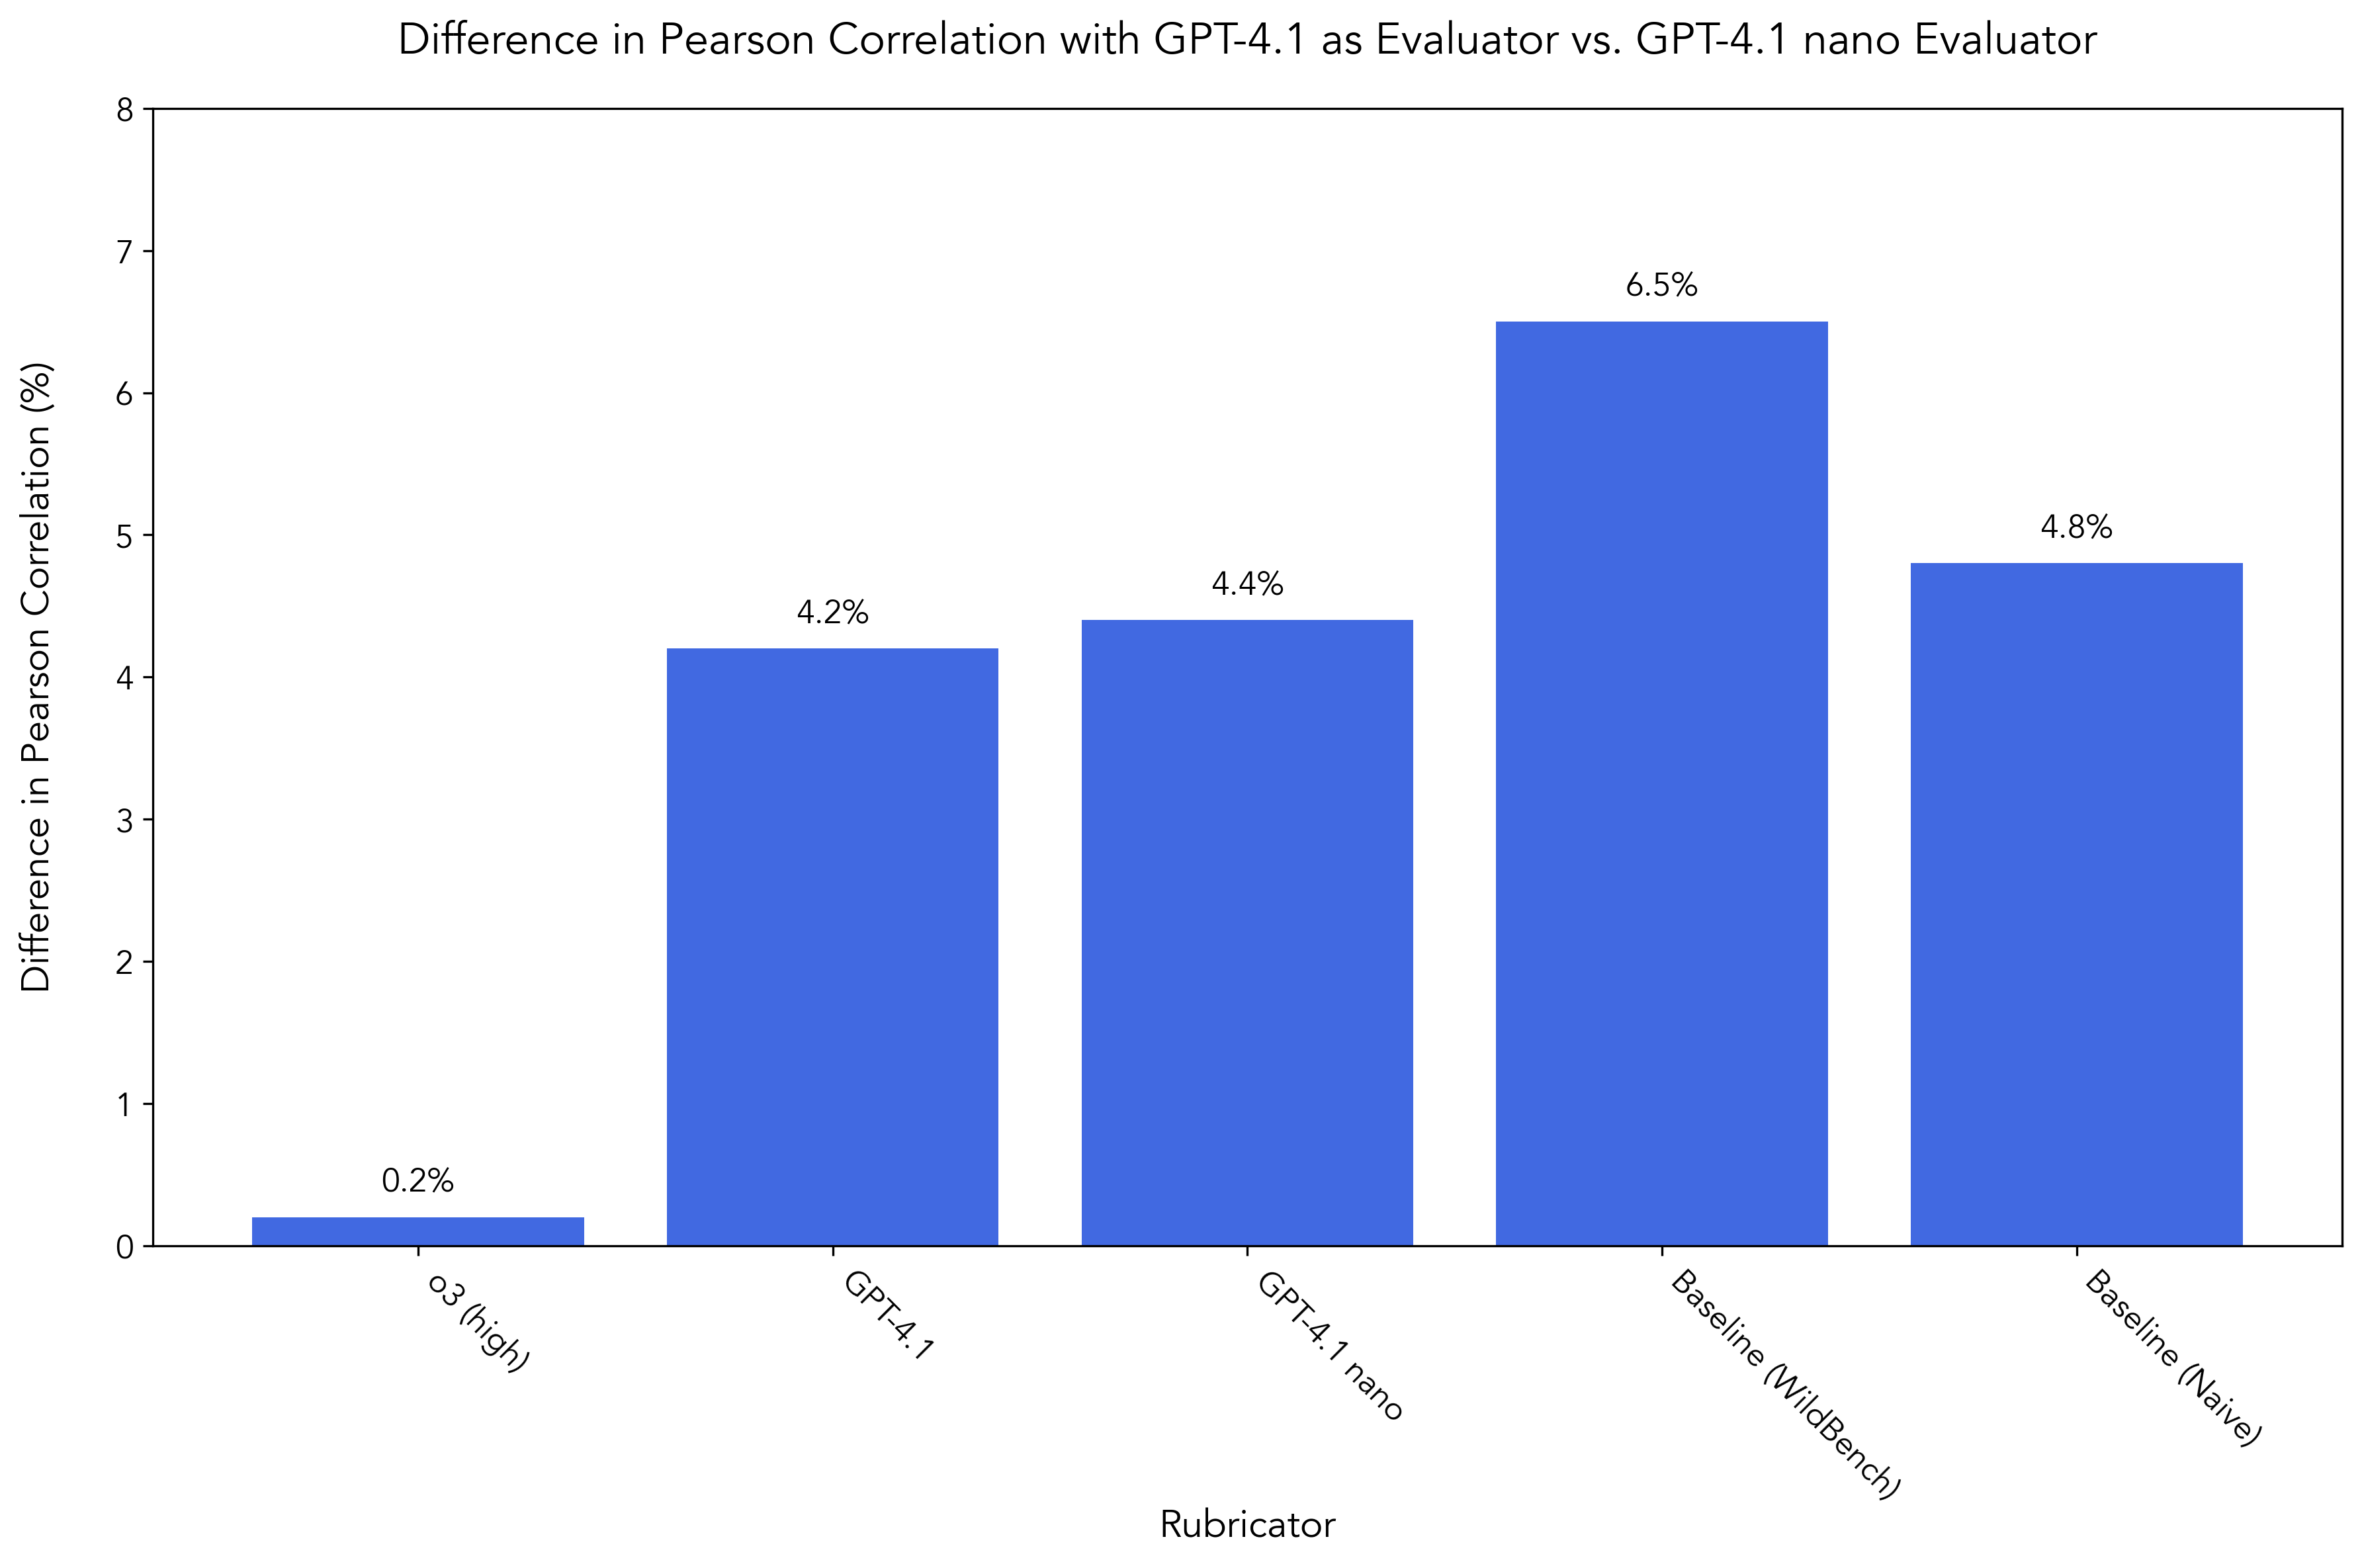

In [673]:
table = get_correlation_tables(["hard_6"], "pearson")[0]
reg_correlations = table.loc["gpt-4.1-2025-04-14_as_evaluator"]
nano_correlations = table.loc["gpt-4.1-nano-2025-04-14_as_evaluator"]
rubricator_pretty_names = ["o3 (high)", "GPT-4.1", "GPT-4.1 nano", "Baseline (WildBench)", "Baseline (Naive)"]
diffs = [(reg_corr - nano_corr) * 100 for reg_corr, nano_corr in zip(reg_correlations, nano_correlations)]

fig = plt.figure(figsize = (12, 8), dpi = 300)
plt.bar(rubricator_pretty_names, diffs, color = "royalblue")
for i, height in enumerate(diffs):
    label_text = format(height, ".1f") + "%"
    plt.annotate(label_text, (i, height), ha = "center", va = "center", xytext = (0, 12), textcoords = "offset points", fontsize = 12)
plt.xticks(rotation = 315, ha = "left")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0, 8)
plt.xlabel("Rubricator", fontsize = 14, labelpad = 0)
plt.ylabel("Difference in Pearson Correlation (%)", fontsize = 14, labelpad = 20)
plt.title("Difference in Pearson Correlation with GPT-4.1 as Evaluator vs. GPT-4.1 nano Evaluator", fontsize = 16, pad = 20)
plt.tight_layout()
plt.show()

In [688]:
def create_range_table(ranges):
    df = pd.DataFrame(ranges, columns = ["evaluator", "rubricator", "range"])
    table = df.pivot(index = "evaluator", columns = "rubricator", values = "range")
    table = table[["o3-2025-04-16_as_rubricator", "gpt-4.1-2025-04-14_as_rubricator", "gpt-4.1-nano-2025-04-14_as_rubricator", "wildbench", "baseline"]]
    table.columns = ["o3-2025-04-16_as_rubricator", "gpt-4.1-2025-04-14_as_rubricator", "gpt-4.1-nano-2025-04-14_as_rubricator", "wildbench_baseline", "naive_baseline"]
    return table

In [692]:
ranges = []

for rubricator in RUBRICATORS:
    for evaluator in EVALUATORS:
        df = get_eval_results(rubricator, evaluator)
        ranges.append((evaluator, rubricator, max(df["score"] - min(df["score"]))))

table = create_range_table(ranges)
print(f"Arena: N/A, Metric: score range, N models: {len(df)}")
display(table)

Arena: N/A, Metric: score range, N models: 33


,o3-2025-04-16_as_rubricator,gpt-4.1-2025-04-14_as_rubricator,gpt-4.1-nano-2025-04-14_as_rubricator,wildbench_baseline,naive_baseline
evaluator,,,,,
gpt-4.1-2025-04-14_as_evaluator,4.33,3.97,3.51,2.78,2.48
gpt-4.1-mini-2025-04-14_as_evaluator,4.52,4.01,3.02,2.36,2.29
gpt-4.1-nano-2025-04-14_as_evaluator,2.69,1.83,1.74,1.97,1.15
